In [1]:
import pyodbc
import pandas as pd
#help(pyodbc.connect)
import scraper
import os
import requests

from datetime import datetime

#conda install -c conda-forge poppler
#pip install pdf2images
#import pdf2images

#pip install PyMuPDF
import fitz

import classification_algorithms 

from IPython.display import Image, display

ModuleNotFoundError: No module named 'classification_algorithms'

In [ ]:
# a.	Choose your option for finding the PDF. 
# Enter the Project Name, Regdocs link or Project Name 
# (Based on the A#, Regdocs link, Project Name)
print("Select an Option:")
print("1. Select Using Project Name /n")
print("2. Select Using Application Number /n")
print("3. Select Using Data ID")
choice = input()

if choice == "1":
    print("Enter Project Name")
elif choice == "2":
    print("Enter Application Number")
elif choice == "3":
    print("Enter DataID")
else:
    print("Please Input a valid choice")
map_key = input()

In [4]:
#dataID = 3891641 for a pdf file
#dataID = 3892301 for a folder
print(choice, map_key)

3 3891641


In [5]:
def list_related_files(choice, map_key):
    """
    b.	Get list of the PDF Files to be downloaded 
    
    Function access the regdocs database and return the DataFrame of the related files
    """
    conn = pyodbc.connect('Driver={SQL Server};'
                          'Server=psql23cap;'
                          'Database=Regulatory_Untrusted;'
                          'Trusted_Connection=yes;')
    
    SQLQuerry = "SELECT TOP (100) [ParentID],[DataID],[Name],[GroupID],[SubType]"
    SQLQuerry = SQLQuerry + ",[Ordering],[ChildCount]"
    SQLQuerry = SQLQuerry + ",[Deleted] FROM [_RegDocs].[DTreeCore]"

    df = pd.DataFrame()
    if choice == "1":
        print("get the names of the PDF Files related to the project name")
    elif choice == "2":
        print("get the names of the PDF Files related to that application number")
    elif choice == "3":
        print("get the names of the PDF Files related to that document number")
        SQLQuerry = SQLQuerry + " where [DataID] = "+ map_key + ""#+ "or [DataID] = 3892301 or [DataID] = 3760157"
        df = pd.read_sql(SQLQuerry,conn)
    #(df.head())
    # print(df)
    return df

df = list_related_files(choice, map_key)
df

get the names of the PDF Files related to that document number


,ParentID,DataID,Name,GroupID,SubType,Ordering,ChildCount,Deleted
0,3892301,3891641,C03383-1 Cover Letter - NGTL Aid to Cross to C...,41490,144,1,0,0


In [6]:
"""conn = pyodbc.connect('Driver={SQL Server};'
                          'Server=psql23cap;'
                          'Database=Regulatory_Untrusted;'
                          'Trusted_Connection=yes;')

SQLQuerry = "SELECT TOP (100) [ParentID],[DataID],[Name],[GroupID],[SubType]"
SQLQuerry = SQLQuerry + ",[Ordering],[ChildCount]"
SQLQuerry = SQLQuerry + ",[Deleted] FROM [_RegDocs].[DTreeCore]"

SQLQuerry = SQLQuerry + " where [DataID] = "+ "948063" #+ "or [DataID] = 3892301 or [DataID] = 3760157"
df = pd.read_sql(SQLQuerry,conn)
df"""

'conn = pyodbc.connect(\'Driver={SQL Server};\'\n                          \'Server=psql23cap;\'\n                          \'Database=Regulatory_Untrusted;\'\n                          \'Trusted_Connection=yes;\')\n\nSQLQuerry = "SELECT TOP (100) [ParentID],[DataID],[Name],[GroupID],[SubType]"\nSQLQuerry = SQLQuerry + ",[Ordering],[ChildCount]"\nSQLQuerry = SQLQuerry + ",[Deleted] FROM [_RegDocs].[DTreeCore]"\n\nSQLQuerry = SQLQuerry + " where [DataID] = "+ "948063" #+ "or [DataID] = 3892301 or [DataID] = 3760157"\ndf = pd.read_sql(SQLQuerry,conn)\ndf'

In [7]:
"""conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=psql23cap;'
                      'Database=Regulatory_Untrusted;'
                      'Trusted_Connection=yes;')

SQLQuerry = "SELECT TOP (100) [ParentID],[DataID],[Name],[GroupID],[DataType],[DCategory],[SubType],[ExAtt1],[ExAtt2]"
SQLQuerry = SQLQuerry + ",[Ordering],[Major],[Minor],[ReleaseRef],[ChildCount],[AssignedTo],[ExtendedData],[Catalog]"
SQLQuerry = SQLQuerry + ",[CacheExpiration],[Deleted],[GUID],[DWAdmin_InsertDateTime] FROM [_RegDocs].[DTreeCore]"
df = pd.read_sql(SQLQuerry,conn)"""

'conn = pyodbc.connect(\'Driver={SQL Server};\'\n                      \'Server=psql23cap;\'\n                      \'Database=Regulatory_Untrusted;\'\n                      \'Trusted_Connection=yes;\')\n\nSQLQuerry = "SELECT TOP (100) [ParentID],[DataID],[Name],[GroupID],[DataType],[DCategory],[SubType],[ExAtt1],[ExAtt2]"\nSQLQuerry = SQLQuerry + ",[Ordering],[Major],[Minor],[ReleaseRef],[ChildCount],[AssignedTo],[ExtendedData],[Catalog]"\nSQLQuerry = SQLQuerry + ",[CacheExpiration],[Deleted],[GUID],[DWAdmin_InsertDateTime] FROM [_RegDocs].[DTreeCore]"\ndf = pd.read_sql(SQLQuerry,conn)'

In [5]:
df

,ParentID,DataID,Name,GroupID,SubType,Ordering,ChildCount,Deleted
0,3892301,3891641,C03383-1 Cover Letter - NGTL Aid to Cross to C...,41490,144,1,0,0


In [8]:
def scrape_PDF_Files(df):
    """
    c.	Download the PDF Files and save the PDF files in a time stamped folder
    
    """
    Index0 = df
       
    count = 0
    error_urls = []
    error_dataIDs = []
    dataID = ""
    
    ##Create New forder for the PDFs downloaded
    now = datetime.now() # current date and time
    timestamp = datetime.timestamp(now)
    new_folder = str(now.strftime("%Y"))+ "." + str(now.strftime("%m"))+ "." + str(now.strftime("%d"))+ "." + str(timestamp)
    path = os.path.realpath('.\\')+ '\\Downloads\\'+new_folder 
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    
    # Itterating each row in the Index0 dataframe 
    download_error = 0
    print("The list of successfully downloaded files are: ")
    for index, row in Index0.iterrows():
        #print(index)
        #print(row)
        
        try:
            dataID = row['DataID']
            download_url = 'http://docs2.cer-rec.gc.ca/ll-eng/llisapi.dll?func=ll&objId=' + str(dataID) + '&objaction=download&viewType=1'
            r = requests.get(download_url) #scraping the PDF file from the URL
            full_name = os.path.join(path + '\\', (str(dataID) +'.pdf')) 
            with open(full_name, 'wb') as file:
                file.write(r.content) 
            count = count + 1
            print(row['Name'])
        except:
            # storing the error logs 
            error_urls.append(download_url)
            error_dataIDs.append(dataID)
            print("error with file {}".format(row['Name']))
            download_error = 1
            
            
    if download_error == 1:
        # creating and and saving the error logs dataframe
        df_scraping_errorlog = pd.DataFrame({'error_dataIDs' : error_dataIDs,
                                             'error_urls' : error_urls
                                              })
        df_scraping_errorlog.to_csv(path + '\\ScrapingErrorLogs.csv', 
                                    index = False, encoding='utf-8-sig')
    return(count, path + "\\")    

count, path = scrape_PDF_Files(df)

The list of successfully downloaded files are: 
C03383-1 Cover Letter - NGTL Aid to Cross to Centra Gas Manitoba - A7A5G4


In [ ]:
def find_maps(df):
    

In [9]:
path

'C:\\Users\\singvibu\\Desktop\\GitHub\\GIS Location Extraction\\Downloads\\2020.09.04.1599247884.498431\\'

In [38]:
"""pdffile = "15-11-30 - Volume 1 - A4W0E2.pdf"
doc = fitz.open(pdffile)
page = doc.loadPage(0)  # number of page
pix = page.getPixmap()
output = "outfile.png"
pix.writePNG(output)"""

'pdffile = "15-11-30 - Volume 1 - A4W0E2.pdf"\ndoc = fitz.open(pdffile)\npage = doc.loadPage(0)  # number of page\npix = page.getPixmap()\noutput = "outfile.png"\npix.writePNG(output)'

In [46]:
doc = fitz.open(path + str(1234) + ".pdf")
page = doc.loadPage(0)
page
pix.writePNG(path + output)
                display(Image(filename = path + output))

page 0 of C:\Users\singvibu\Desktop\GitHub\GIS Location Extraction\Downloads\2020.09.03.1599150966.90701\1234.pdf

In [48]:
for page_no in range(len(doc)):
    page = doc.loadPage(page_no)
    pix = page.getPixmap()
    output = str("1234_" + str(page_no)+ ".png"
                
    pix.writePNG(path + output)
    display(Image(filename = path + output))
    print(page.getDisplayList())
    print(page)
    display(Image(filename = path + output))

SyntaxError: invalid syntax (<ipython-input-48-b60ca42466f2>, line 6)

"C:\Users\singvibu\Desktop\GitHub\GIS Location Extraction\Downloads\2020.09.02.1599099952.311381\3891641.pdf"

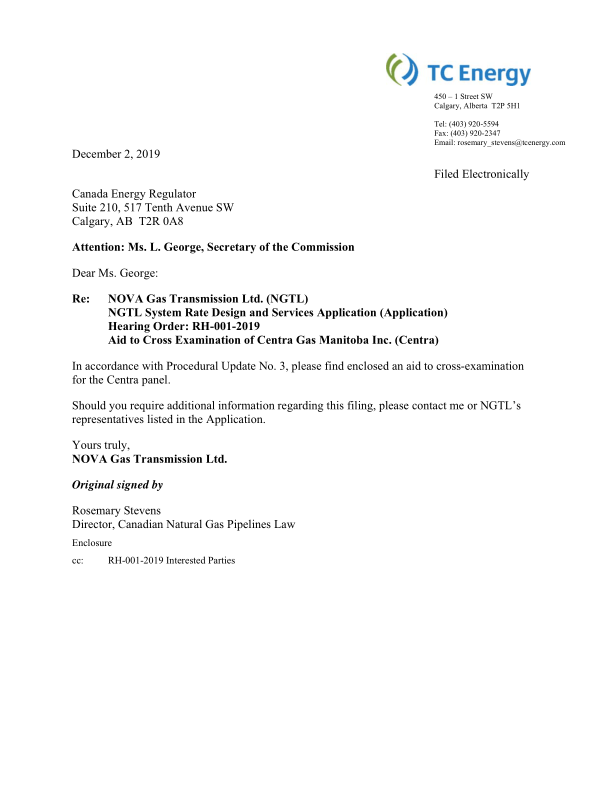

0

3891641_0.png


In [7]:
def convert_pdf_to_images(Index0, path):
    
    download_error = 0
    error_urls = []
    for index, row in Index0.iterrows():
        #print(index)
        #print(row)
        
        try:
            file = path + str(row['DataID']) + ".pdf"
            doc = fitz.open(file)
            
            for page_no in range(len(doc)):
                #i = i+1
                #try:
                page = doc.loadPage(page_no)  # number of page
                pix = page.getPixmap()
                #pix.display()
                output = str(row['DataID']) + "_" + str(page_no)+ ".png"
                pix.writePNG(path + output)
                display(Image(filename = path + output))
                print(output)
                #display(file = path + output)
                #except:
                #    print("Error with page {}".format(i)) 
        except:
            # storing the error logs 
            error_urls.append(row['DataID'])
            print("Could con convert the PDF {} to image".format(row['DataID']))
            download_error = 1
            
            
    if download_error == 1:
        # creating and and saving the error logs dataframe
        df_scraping_errorlog = pd.DataFrame({'error_dataIDs' : error_urls
                                              })
        df_scraping_errorlog.to_csv(path + 'ScrapingErrorLogs.csv', 
                                    index = False, encoding='utf-8-sig')
    return(0)    

convert_pdf_to_images(df, path)
    

In [43]:
path + "3891641_0.png"

'C:\\Users\\singvibu\\Desktop\\GitHub\\GIS Location Extraction\\Downloads\\2020.09.03.1599150966.90701\\3891641_0.png'